<a href="https://colab.research.google.com/github/Eric-0522/Eric-0522.github.io/blob/main/cmdline_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 1

- 嘗試使用 LLM 來判斷是否為惡意 Cmdline
    - https://chatgpt.com
    - https://claude.ai
    - https://gemini.google.com
- 嘗試用不同的 Promt、給不同的 Cmdline
- 試試看不同的模型回答差異

In [ ]:
# Download data
!gdown 1KB3GWRA2cToMoXFANacVJLeOQSGQNPP9

Downloading...
From: https://drive.google.com/uc?id=1KB3GWRA2cToMoXFANacVJLeOQSGQNPP9
To: /content/cmdline.json
100% 9.91k/9.91k [00:00<00:00, 32.9MB/s]


1. 左邊點資料夾圖案，點兩下 cmdline.json 查看
2. 對打開的 json 按右鍵 Format document 可以轉成好看的格式

# Lab 2

比較 Cmdline 經過 LLM Embed 後的差異
- OpenAI: text-embedding-3-small
- Jina: jina/jina-embeddings-v2-base-en

In [ ]:
# Download data
!gdown 1YYi4TfybXIZphr6Y5lXvhRD_QAITBKU6

Downloading...
From: https://drive.google.com/uc?id=1YYi4TfybXIZphr6Y5lXvhRD_QAITBKU6
To: /content/embedded_cmdline.pickle
100% 2.71M/2.71M [00:00<00:00, 212MB/s]


In [ ]:
# Read data from embedded_cmdline.pickle
import pickle
with open('embedded_cmdline.pickle', 'rb') as f:
    data = pickle.load(f)

mal = data['malicious']
ben = data['benign']

# Embedding size for openai and jina
print(len(mal[0][0]['openai']))
print(len(mal[0][0]['jina']))

1536
768


In [ ]:
import numpy as np

# load the emebeddings
def load_embeddings(data):
  openai = []
  jina = []
  for proc in data:
    for cmd in proc:
      openai.append(cmd['openai'])
      jina.append(cmd['jina'])

  return openai, jina

openai_mal, jina_mal = load_embeddings(mal)
openai_ben, jina_ben = load_embeddings(ben)

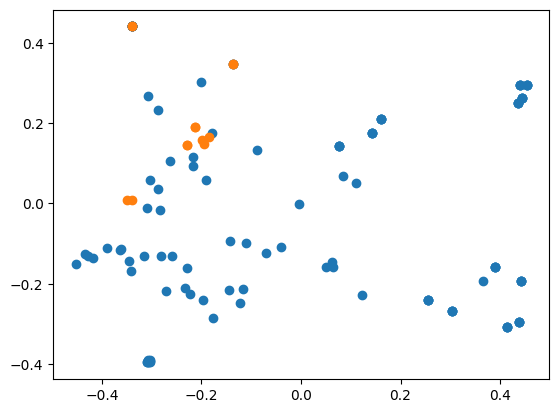

<Figure size 640x480 with 0 Axes>

In [ ]:
# use PCA on openai embeddings
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(openai_mal + openai_ben)
openai_mal_pca = pca.transform(openai_mal)
openai_ben_pca = pca.transform(openai_ben)

# plot
import matplotlib.pyplot as plt
plt.scatter(openai_mal_pca[:, 0], openai_mal_pca[:, 1], label='malicious')
plt.scatter(openai_ben_pca[:, 0], openai_ben_pca[:, 1], label='benign')
plt.show()
plt.clf()

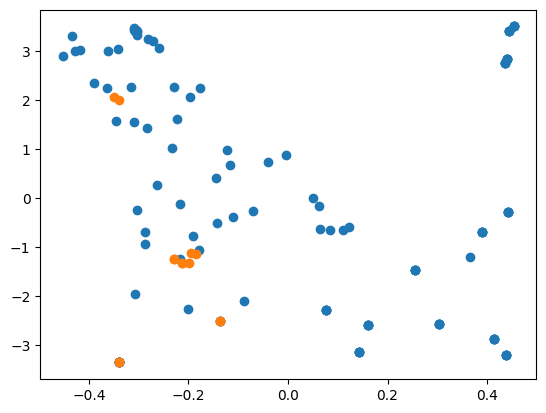

In [ ]:
# use PCA on jina embeddings

pca = PCA(n_components=2)
pca.fit(jina_mal + jina_ben)
jina_mal_pca = pca.transform(jina_mal)
jina_ben_pca = pca.transform(jina_ben)

# plot
plt.scatter(openai_mal_pca[:, 0], jina_mal_pca[:, 1], label='malicious')
plt.scatter(openai_ben_pca[:, 0], jina_ben_pca[:, 1], label='benign')
plt.show()
plt.clf()

# Lab 3

訓練一個 BERT 模型來辨識 Cmdline 是否為惡意
- 惡意程式的 Cmdline 都當成惡意
- 正常程式的 Cmdline 都當成正常

In [ ]:
# Load cmdline.json
import json
with open('cmdline.json', 'r') as f:
    data = json.load(f)

# Collect malicious and benign cmdline
malcmd = []
bencmd = []
for proc in data['malicious']:
  for cmd in proc:
    malcmd.append(cmd)

for proc in data['benign']:
  for cmd in proc:
    bencmd.append(cmd)

# print parsed cmd
print(len(malcmd), len(bencmd))
print(malcmd[:2])

117 13
['/c schtasks /Create /SC once /TN "" /TR "C:\\Windows\\system32\\shutdown.exe /r /f" /ST 11:41', '"C:\\Users\\<USERNAME>\\AppData\\Local\\Temp\\6F89.tmp" \\\\.\\pipe\\{71084112-C648-476A-9EAF-422B101A3EB7}']


In [ ]:
# Train a BERT model to classify malcmd and bencmd
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split

benign_labels = [0] * len(bencmd)
malicious_labels = [1] * len(malcmd)

commands = bencmd + malcmd
labels = benign_labels + malicious_labels

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenizing inputs
encodings = tokenizer(commands, padding=True, truncation=True, return_tensors='pt')

# Split data into train and test
train_texts, test_texts, train_labels, test_labels = train_test_split(encodings['input_ids'], labels, test_size=0.2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Encoded text
print(train_texts[0])
print(train_labels[0])

# Decoded text
decoded_text = tokenizer.decode(train_texts[0], skip_special_tokens=True)
print(decoded_text)

tensor([  101,  1013,  1039,  4647,  5732,  4183,  1013,  2275,  1063, 12398,
         1065,  7233,  8189, 23242,  2053,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
1
/ c bcdedit / set { default } recoveryenabled no


In [ ]:
# Model preparing
from transformers import BertForSequenceClassification
import torch

# Load the BERT model for classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Prepare the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Model training
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# Convert to tensors
train_dataset = TensorDataset(train_texts, torch.tensor(train_labels))
test_dataset = TensorDataset(test_texts, torch.tensor(test_labels))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

# Training loop
model.train()
for epoch in range(3):  # Number of epochs can be adjusted
    for batch in tqdm(train_loader):
        inputs, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        print(f"Loss: {loss.item()}")

  8%|▊         | 1/13 [00:06<01:19,  6.60s/it]

Loss: 0.2700032889842987


 15%|█▌        | 2/13 [00:12<01:06,  6.00s/it]

Loss: 0.6929646134376526


 23%|██▎       | 3/13 [00:18<01:02,  6.20s/it]

Loss: 0.20739184319972992


 31%|███       | 4/13 [00:23<00:52,  5.79s/it]

Loss: 0.4106372594833374


 38%|███▊      | 5/13 [00:30<00:48,  6.01s/it]

Loss: 0.5523190498352051


 46%|████▌     | 6/13 [00:35<00:40,  5.77s/it]

Loss: 0.37677276134490967


 54%|█████▍    | 7/13 [00:40<00:34,  5.67s/it]

Loss: 0.37012746930122375


 62%|██████▏   | 8/13 [00:46<00:28,  5.76s/it]

Loss: 0.40134087204933167


 69%|██████▉   | 9/13 [00:52<00:22,  5.61s/it]

Loss: 0.6119664311408997


 77%|███████▋  | 10/13 [00:58<00:17,  5.86s/it]

Loss: 0.19766414165496826


 85%|████████▍ | 11/13 [01:03<00:11,  5.67s/it]

Loss: 0.39687836170196533


 92%|█████████▏| 12/13 [01:10<00:05,  5.91s/it]

Loss: 0.377310186624527


100%|██████████| 13/13 [01:15<00:00,  5.81s/it]


Loss: 0.18648339807987213


  8%|▊         | 1/13 [00:06<01:13,  6.12s/it]

Loss: 0.16325543820858002


 15%|█▌        | 2/13 [00:11<01:01,  5.59s/it]

Loss: 0.36651527881622314


 23%|██▎       | 3/13 [00:16<00:54,  5.42s/it]

Loss: 0.1356278955936432


 31%|███       | 4/13 [00:22<00:51,  5.73s/it]

Loss: 0.12369891256093979


 38%|███▊      | 5/13 [00:27<00:44,  5.51s/it]

Loss: 0.3516281247138977


 46%|████▌     | 6/13 [00:34<00:40,  5.82s/it]

Loss: 0.10728293657302856


 54%|█████▍    | 7/13 [00:39<00:33,  5.61s/it]

Loss: 0.9849606156349182


 62%|██████▏   | 8/13 [00:45<00:29,  5.85s/it]

Loss: 0.09862107038497925


 69%|██████▉   | 9/13 [00:51<00:22,  5.64s/it]

Loss: 0.40174001455307007


 77%|███████▋  | 10/13 [00:56<00:17,  5.71s/it]

Loss: 0.08818565309047699


 85%|████████▍ | 11/13 [01:02<00:11,  5.65s/it]

Loss: 0.7209517955780029


 92%|█████████▏| 12/13 [01:07<00:05,  5.52s/it]

Loss: 0.39494115114212036


100%|██████████| 13/13 [01:13<00:00,  5.68s/it]


Loss: 1.343534231185913


  8%|▊         | 1/13 [00:05<01:02,  5.21s/it]

Loss: 0.09399533271789551


 15%|█▌        | 2/13 [00:11<01:05,  5.92s/it]

Loss: 0.09606841206550598


 23%|██▎       | 3/13 [00:16<00:55,  5.59s/it]

Loss: 0.10204220563173294


 31%|███       | 4/13 [00:23<00:52,  5.84s/it]

Loss: 1.1645996570587158


 38%|███▊      | 5/13 [00:28<00:45,  5.64s/it]

Loss: 0.6463962197303772


 46%|████▌     | 6/13 [00:34<00:39,  5.68s/it]

Loss: 0.6187565326690674


 54%|█████▍    | 7/13 [00:39<00:34,  5.74s/it]

Loss: 0.14121979475021362


 62%|██████▏   | 8/13 [00:45<00:27,  5.58s/it]

Loss: 0.3701860010623932


 69%|██████▉   | 9/13 [00:51<00:23,  5.78s/it]

Loss: 0.14877007901668549


 77%|███████▋  | 10/13 [00:56<00:16,  5.60s/it]

Loss: 0.5714972615242004


 85%|████████▍ | 11/13 [01:03<00:11,  5.85s/it]

Loss: 0.18420366942882538


 92%|█████████▏| 12/13 [01:08<00:05,  5.66s/it]

Loss: 0.3792286813259125


100%|██████████| 13/13 [01:14<00:00,  5.74s/it]

Loss: 0.3390888273715973


In [ ]:
# Model Testing
from sklearn.metrics import accuracy_score

model.eval()
predictions, true_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        outputs = model(inputs)
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, dim=1).tolist())
        true_labels.extend(labels.tolist())

accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 1.0


In [ ]:
# Test with given command line
def classify_command(command, model, tokenizer):
    """
    Classify a command as benign or malicious using a fine-tuned BERT model.

    Parameters:
    - command (str): The command string to classify.
    - model (BertForSequenceClassification): The fine-tuned BERT model.
    - tokenizer (BertTokenizer): The BERT tokenizer.

    Returns:
    - result (str): 'Benign' or 'Malicious' based on the prediction.
    """
    # Tokenize the input command
    inputs = tokenizer(command, return_tensors='pt', padding=True, truncation=True)

    # Set the model to evaluation mode
    model.eval()

    # Perform the prediction
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=1).item()

    # Map the prediction to human-readable labels
    label_map = {0: "Benign", 1: "Malicious"}
    return label_map[prediction]

print(classify_command("del C:\\Windows\\System32\\*.* /F /S /Q", model, tokenizer))
print(classify_command("ls", model, tokenizer))

Malicious
Malicious


# Lab 4 Critical Token Identification
- 以 BERT Embedding 為例
- 將不同的 Token (單詞) 移除，比較 Embedding 的差異
- 差異使用 Cosine Similarity 來計算


In [ ]:
import torch
from transformers import BertTokenizer, BertModel
from scipy.spatial.distance import cosine
from scipy.spatial.distance import euclidean

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embedding(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors='pt')

    # Get BERT embeddings
    with torch.no_grad():
        outputs = model(**inputs)
        # Get the embeddings for [CLS] token (first token)
        embedding = outputs.last_hidden_state[:, 0, :]
    return embedding.squeeze().numpy()

# Original text
text = "/c schtasks /Create /SC once /TN \"\" /TR \"C:\\Windows\\system32\\shutdown.exe /r /f\" /ST 11:41"
#text = "/c wevtutil cl security"
#text = "wmic  shadowcopy delete"

# Tokenize the text into tokens
tokens = tokenizer.tokenize(text)

# Get the embedding for the original text
original_embedding = get_bert_embedding(text)

# Get embeddings for versions of the text with each token removed
for i, token in enumerate(tokens):
    # Remove the ith token and re-create the string
    modified_tokens = tokens[:i] + tokens[i+1:]
    modified_text = tokenizer.convert_tokens_to_string(modified_tokens)

    # Get the embedding for the modified text
    modified_embedding = get_bert_embedding(modified_text)

    # Calculate cosine similarity between original and modified embeddings
    similarity = 1 - cosine(original_embedding, modified_embedding)
    distance = euclidean(original_embedding, modified_embedding)

    print(token, similarity, distance, sep='\t')

/	0.9954429293999908	1.3481229543685913
c	0.997178950244769	1.0635558366775513
sc	0.9955916879100972	1.3477747440338135
##hta	0.9980272874047735	0.8918012380599976
##sk	0.9987190148435604	0.7155655026435852
##s	0.998866938512	0.6727862358093262
/	0.9948231580320851	1.436657428741455
create	0.9972653535831298	1.0507041215896606
/	0.995750811234578	1.3081250190734863
sc	0.997562687838433	0.9900144934654236
once	0.9984386087015468	0.7909508347511292
/	0.9974200961110209	1.0178818702697754
tn	0.9955790619407892	1.328908920288086
"	0.9913454677168905	1.8567408323287964
"	0.9913454677168905	1.8567408323287964
/	0.9930924152800807	1.662580132484436
tr	0.9954648666591847	1.3465086221694946
"	0.9940607122814588	1.541910171508789
c	0.9952045390473905	1.3828500509262085
:	0.9975209264079238	1.0007675886154175
\	0.9981444430453411	0.8622602820396423
windows	0.9945303006777387	1.4812431335449219
\	0.9984003276129764	0.799477756023407
system	0.9970810868324677	1.0822982788085938
##32	0.9984887718771

In [ ]:
# Original text
#text = "/c schtasks /Create /SC once /TN \"\" /TR \"C:\\Windows\\system32\\shutdown.exe /r /f\" /ST 11:41"
#text = "/c wevtutil cl security"
text = "wmic  shadowcopy delete"

# Get the embedding for the original text
original_embedding = get_bert_embedding(text)

# Get embeddings for versions of the text with each token removed
text = text.replace('\"', ' ').replace('\\', ' ')
tokens = text.split(' ')
for i, token in enumerate(tokens):
    # Remove the ith token and re-create the string
    modified_tokens = tokens[:i] + tokens[i+1:]
    modified_text = ' '.join(modified_tokens)

    # Get the embedding for the modified text
    modified_embedding = get_bert_embedding(modified_text)

    # Calculate cosine similarity between original and modified embeddings
    similarity = 1 - cosine(original_embedding, modified_embedding)
    distance = euclidean(original_embedding, modified_embedding)

    print(token, similarity, distance, sep='\t')

wmic	0.965489759368684	3.831803798675537
	1.0	0.0
shadowcopy	0.9554551438784604	4.301915645599365
delete	0.9323730598336344	5.329345226287842
